# Discretization Classification 2.0(Template) - KFold
## Author: Ming

## Import Package

In [1]:
#Import Package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn import preprocessing 


#Discretization
from mdlp.discretization import MDLP
from caimcaim import CAIMD
from scorecardbundle.feature_discretization import ChiMerge as cm
from reportgen import preprocessing #Chimerge

from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score, confusion_matrix

from threading import Thread, Lock
lock = Lock()

import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()

#Import Our Class
%run "TEJ Classification Package.ipynb"

## 1.Load Data

In [2]:
# Load Data
data_name = "Tsai_Original"
#Fast: Japanese_Credit Australian_Original Germany_Original Japanese_Bankrupt 
#Slow: USA_Bankrupt

#Discretize Good: Kaggle Tsai Bankruptcy Australia JPNCredit
#
if data_name == "Tsai_Original":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_Tsai_BankruptcyData()
elif  data_name == "Germany_Original":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_German_Numeric_CreditData()
elif  data_name == "Germany_700-300(Random)":
    germanData_data_sample, discretize_coloumn = ClassificationDataset().load_German_Numeric_CreditData_Dataframe()
elif  data_name == "Australian_Original":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_Australian_CreditData()
elif  data_name == "Australian_Normalize(Old)":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_Australian_CreditData_Normalize()
elif  data_name == "Australian_(Dis5Column)Without12":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_Australian_CreditData_Different_Continuous_Column()
elif  data_name == "GiveMeSomeCredit":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_GiveMeSomeCredit_CreditData() 
elif  data_name == "Japanese_Credit":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_Japanese_CreditData() 
elif  data_name == "Japanese_Bankrupt":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_Japanese_BankruptData() 
elif  data_name == "USA_Bankrupt":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_USA_BankruptData()
elif  data_name == "Bankruptcy":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_Bankruptcy_Data() 
elif  data_name == "TEJCN":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_TEJCN_Data() 
elif  data_name == "PAKDD":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_PAKDD_Data() 
 

## 2.Sampling

In [3]:
# Sampling
# large = germanData_data_sample.loc[germanData_data_sample['default'] == 1]
# small = germanData_data_sample.loc[germanData_data_sample['default'] == 2]
# large = large.sample(n=300)
# germanData_data = pd.concat([large, small])
# germanData_data = germanData_data.sample(frac=1).reset_index(drop=True)
# data_list = germanData_data[[i for i in germanData_data.columns if i != 'default']].values
# target_list = germanData_data[[i for i in germanData_data.columns if i == 'default']].values

In [4]:
print ("資料筆數 ::", data_list.shape[0])
print ("特徵數量(不含Target) ::", data_list.shape[1])

資料筆數 :: 6819
特徵數量(不含Target) :: 95


In [5]:
unique, counts = np.unique(target_list, return_counts=True)
dict(zip(unique, counts)) #Major:1 ; minor2

{0: 6599, 1: 220}

## Discretization_Python
Select Specific Features to Discretization + Discretization Method (MDLP、CAIM、ChiMerge)

In [6]:
class Discretization:
    def __init__(self, training_data, training_target, discretize_coloumn):
        self.training_data = training_data
        self.training_target = training_target
        self.discretize_coloumn = discretize_coloumn
        self.transformer_MDLP = MDLP()
        self.transformer_CAIMD = CAIMD()
        self.transformer_ChiMerge_SC = cm.ChiMerge(output_dataframe=True)
        self.transformer_ChiMerge_RG = preprocessing.Discretization(method='chimerge')

    def SelectFeatures(self): ##Split Specific to Discretize
        idx_IN_columns = self.discretize_coloumn
        idx_OUT_columns = [i for i in range(np.shape(self.training_data)[1]) if i not in idx_IN_columns]
        selectData_list = self.training_data[:,idx_IN_columns]
        disSelectData_list = self.training_data[:,idx_OUT_columns]
        return selectData_list , disSelectData_list
        
    def MDLP(self,selectData_list): 
        selectDataDiscretiz_list = self.transformer_MDLP.fit_transform(selectData_list, self.training_target)
        return selectDataDiscretiz_list
    
    def MDLP_transform(self,selectData_test_list): 
        selectDataDiscretiz_list = self.transformer_MDLP.transform(selectData_test_list)
        return selectDataDiscretiz_list

    def CAIMD(self,selectData_list):  #CAIMD
        selectDataDiscretiz_list = self.transformer_CAIMD.fit_transform(selectData_list, self.training_target)
        return selectDataDiscretiz_list
    
    def CAIMD_transform(self,selectData_test_list):  #CAIMD
        selectDataDiscretiz_list = self.transformer_CAIMD.transform(selectData_test_list)
        return selectDataDiscretiz_list
    
    def ChiMerge_SC(self,selectData_list):  #Chimerge
        selectDataDiscretiz_list = self.transformer_ChiMerge_SC.fit_transform(selectData_list, self.training_target.squeeze())
        return self.Box_Transform(selectDataDiscretiz_list)
    
    def ChiMerge_SC_transform(self,selectData_test_list):  #Chimerge
        selectDataDiscretiz_list = self.transformer_ChiMerge_SC.transform(selectData_test_list)
        return self.Box_Transform(selectDataDiscretiz_list)
    
    def ChiMerge_RG(self,selectData_list):  #Chimerge
        selectDataDiscretiz_list = self.transformer_ChiMerge_RG.fit_transform(selectData_list, self.training_target.squeeze())
        return self.Box_Transform(selectDataDiscretiz_list)
    
    def ChiMerge_RG_transform(self,selectData_test_list):  #Chimerge
        selectDataDiscretiz_list = self.transformer_ChiMerge_RG.transform(selectData_test_list)
        return self.Box_Transform(selectDataDiscretiz_list)
    
    def Box_Transform(self,discretize_list):
        for i in discretize_list.columns:
            replace_coloumn = discretize_list[i].unique()
            replace_coloumn.sort()
            lst = list(replace_coloumn)
            ip_dict = dict(zip(lst, range(len(lst))))
            discretize_list[i] = discretize_list[i].replace(ip_dict)
        return discretize_list
    
    def MergeFeatures(self,selectDataDiscretiz_list,disSelectData_list):  ## Merge Discretized Data with Original Data
        self.dataDiscretize_list = np.concatenate([selectDataDiscretiz_list,disSelectData_list],axis = 1)
        return self.dataDiscretize_list

## Discretization Utility

In [7]:
class Discretization_utility:
    def __init__(self, continuous_data, discretize_coloumn):
        self.continuous_data_dataframe = continuous_data
        self.discretize_coloumn = discretize_coloumn

    # Deprecated
#     def SelectFeatures(self): ##Split Specific to Discretize
#         idx_IN_columns = self.discretize_coloumn
#         idx_OUT_columns = [i for i in range(np.shape(self.training_data)[1]) if i not in idx_IN_columns]
#         selectData_list = self.training_data[:,idx_IN_columns]
#         disSelectData_list = self.training_data[:,idx_OUT_columns]
#         return selectData_list , disSelectData_list
    
    def SelectFeatures(self): ##Split Specific to Discretize
        idx_IN_columns = self.discretize_coloumn
        idx_OUT_columns = [i for i in range(np.shape(self.continuous_data_dataframe)[1]) if i not in idx_IN_columns]
        selectData_list = self.continuous_data_dataframe.iloc[:,idx_IN_columns]
        disSelectData_list = self.continuous_data_dataframe.iloc[:,idx_OUT_columns]
        return selectData_list , disSelectData_list
    
    def PrintFirstFiveData(self,data,dataname): ##Split Specific to Discretize
        #print("["+str(dataname)+"]")
        #print(data.head(5))
        return 0
     

## Discretization with R
R package'Discretization'

In [8]:
class Discretization_rpy2:
    ## Input:X_train,y_train,X_test,y_test,discretize_coloumn,method
    ## Output: Discretize_X_train_dataframe, y_train_dataframe, Discretize_X_test_dataframe, y_test_dataframe
    
    def discretize(X_train,y_train,X_test,y_test,discretize_coloumn,method):

        # Declare Discretizer_rpy2 (Select Continuous Feature, PrintFirstFive)
        discretize_train = Discretization_utility(X_train,discretize_coloumn)

        # Select Continuous Feature (Training Data Continuous Feature)
        X_train_continuousData_list, X_train_catrgorialData_list  = discretize_train.SelectFeatures() #Devide Discretize Coloumns


        # Convert data to Dataframe for R Package "Discretization"
        ## R 'Discretization' require Continuous Data(X_Train_SelectData) and Target(y_Train) in the last column
        X_train_continuousData_dataframe = pd.DataFrame(X_train_continuousData_list)
        y_train_dataframe = pd.DataFrame(y_train)

        # Combine Select Continuous with Target
        X_y_train_continuousData_dataframe = pd.concat([X_train_continuousData_dataframe, y_train_dataframe],axis=1)
        X_y_train_continuousData_dataframe.columns = range(X_y_train_continuousData_dataframe.shape[1]) #Reshape for column index
        discretize_train.PrintFirstFiveData(X_y_train_continuousData_dataframe,"X_y_train_continuousData_dataframe")


        # Import R Package
        discretization = importr("discretization")
        disc_Topdown = robjects.r("disc.Topdown")

        print("-------------------------------"+method+" -----------------------------")

        # Discretize (R Package)
        ## Input: pandas.DataFrame  Output: rpy2.DataFrame
        if method == 'MDLP_R':
            X_y_train_disData_rpy2dataframe = discretization.mdlp(X_y_train_continuousData_dataframe)
        elif method == 'CAIM_R':
            X_y_train_disData_rpy2dataframe = discretization.disc_Topdown(X_y_train_continuousData_dataframe, method=1)
        elif method == 'ChiMerge_R':
            X_y_train_disData_rpy2dataframe = discretization.chiM(X_y_train_continuousData_dataframe, alpha = 0.05)
        elif method == 'CACC_R':
            X_y_train_disData_rpy2dataframe = discretization.disc_Topdown(X_y_train_continuousData_dataframe, method=2)
        elif method == 'Chi2_R':
            X_y_train_disData_rpy2dataframe = discretization.chi2(X_y_train_continuousData_dataframe,0.5,0.05)

        # Transfer rpy2.DataFrame to pandas.DataFrame
        X_y_train_disData_dataframe = pandas2ri.ri2py(X_y_train_disData_rpy2dataframe[1])
        discretize_train.PrintFirstFiveData(X_y_train_disData_dataframe,"X_y_train_disData_dataframe")


        # Select the data(without target) in Combine_X_y_train_dis_dataframe 
        X_train_disData_dataframe = X_y_train_disData_dataframe.iloc[:,:-1]
        discretize_train.PrintFirstFiveData(X_train_disData_dataframe,"X_train_disData_dataframe")


        # Merge dis_feature & categeorial_feature
        X_train_categorialData_dataframe = pd.DataFrame(X_train_catrgorialData_list)
        discretize_train.PrintFirstFiveData(X_train_categorialData_dataframe,"X_train_categorialData_dataframe")            
        Discretize_X_train_dataframe = pd.concat([X_train_disData_dataframe, X_train_categorialData_dataframe],axis = 1)
        Discretize_X_train_dataframe.columns = range(Discretize_X_train_dataframe.shape[1])
        discretize_train.PrintFirstFiveData(Discretize_X_train_dataframe,"Discretize_X_train_dataframe")


        # --------------------------------------Discretize Testing Data----------------------------------------------------

        # Enable Cutpoint for X_test (No Target)

        ## Declare Discretization_utility
        discretize_test = Discretization_utility(X_test,discretize_coloumn)

        ## Select Continuous Feature (Testing Data Continuous Feature)
        ## Return: List of data
        X_test_continuousData_list, X_test_catrgorialData_list  = discretize_test.SelectFeatures() #Devide Discretize Coloumns


        ## Prepare X_test to enable cutpoint
        X_test_continuousData_dataframe  = pd.DataFrame(X_test_continuousData_list)
        discretize_train.PrintFirstFiveData(X_test_continuousData_dataframe,"X_test_continuousData_dataframe")


        ## Get Cutpoint (Transfer to numpy array)
        cutpoint_bins = X_y_train_disData_rpy2dataframe[0]
        #cutpoint_bins = np.array(cutpoint)
        #print("Original Cutbins")
        #print(cutpoint_bins)


        ## Declare dataframe for store data after discretize
        X_test_disData_dataframe = pd.DataFrame()

        # Iterate the cutbin to pd.cut the data
        for idx, val in enumerate(X_test_continuousData_dataframe):
            if cutpoint_bins[idx][0] == "All":
                #print(str(idx)+"_ALL")
                X_test_disData_dataframe[idx] = pd.cut(X_test_continuousData_dataframe.iloc[:,idx], bins =1 , labels = [1],include_lowest=True )    
            else:        
                #print(str(idx)+"_NOTALL")
                cutpoint_bins[idx] = np.sort(cutpoint_bins[idx])
                #print(type(cutpoint_bins[idx]))
                cutpoint_with_infiniti = np.insert (np.insert(cutpoint_bins[idx],0, (-np.inf),0),len(cutpoint_bins[idx])+1,(np.inf))
                cutpoint_labels = list(range(1, len(cutpoint_with_infiniti)))
                #print(cutpoint_labels)

                X_test_disData_dataframe[idx] = pd.cut(X_test_continuousData_dataframe.iloc[:,idx], bins = cutpoint_with_infiniti,labels=cutpoint_labels,include_lowest=True)
        discretize_train.PrintFirstFiveData(X_test_disData_dataframe,"X_test_disData_dataframe")


        # Merge dis_feature & categeorial_feature
        X_test_categorialData_dataframe = pd.DataFrame(X_test_catrgorialData_list)
        discretize_train.PrintFirstFiveData(X_test_categorialData_dataframe,"X_test_categorialData_dataframe")

        Discretize_X_test_dataframe = pd.concat([X_test_disData_dataframe, X_test_categorialData_dataframe],axis=1)
        Discretize_X_test_dataframe.columns = range(Discretize_X_test_dataframe.shape[1])
        discretize_train.PrintFirstFiveData(Discretize_X_test_dataframe,"Discretize_X_test_dataframe")


        # Convert Target to Dataframe
        y_train_dataframe = pd.DataFrame(y_train)
        y_test_dataframe = pd.DataFrame(y_test)
        
        return Discretize_X_train_dataframe, y_train_dataframe, Discretize_X_test_dataframe, y_test_dataframe


## KFoldFuntion

In [9]:
class KFoldFuntion:
    # classifier, 
    # linear_svc,'linear_svc','','None','None','Dis-None', data_list, target_list, fold
    def __init__(self, classifier, classifier_name, discretization_method, fs_method, method_order, data_list, target_list, fold, discretize_coloumn):
        self.X = data_list
        self.y = target_list
        self.fold = fold
        self.outcomes_acc = []
        self.outcomes_auc = []
        self.outcomes_typeII = []
        self.outcomes_typeI = []
        self.fold_result_list = []
        self.outcomes_minority = []
        self.outcomes_majority = []
        self.discretization_method = discretization_method  # (None, MDLP, CAIM)
        self.fs_method = fs_method  # (None, C4.5, PCA, GA)
        self.method_order = method_order # (None-None, Dis-None, Dis-FS, FS-None, FS-Dis)
        self.classifier = classifier
        self.classifier_name = classifier_name
        self.discretize_coloumn = discretize_coloumn
    
    def Classify(self):
        # Main function
        ## Cross Validation, Discretization, (Feature Selection), Classifier
        
        kf = KFold(n_splits=self.fold,random_state=np.random, shuffle=True)
        #kf = StratifiedKFold(n_splits=self.fold)
        for train_index, test_index in kf.split(self.X):
            X_train, X_test = self.X[train_index], self.X[test_index] #X_train: training data X_test: testing data
            y_train, y_test = self.y[train_index], self.y[test_index] #y_train: training data answer y_test: testing data answer
            
            # Convert to Dataframe
            X_train_dataframe = pd.DataFrame(X_train)
            X_test_dataframe  = pd.DataFrame(X_test)
            y_train_dataframe = pd.DataFrame(y_train)
            y_test_dataframe  = pd.DataFrame(y_test)
            
            # Decide the process order (Dis-FS or FS-None)
            first_method, second_method = self.method_order.split('-')
            
            # Pre-Proecessing
            if first_method== 'Dis' and first_method != 'None':
                print("Discretization")
                X_train_dataframe, y_train_dataframe, X_test_dataframe, y_test_dataframe = Discretization_rpy2.discretize(X_train_dataframe,y_train_dataframe,X_test_dataframe,y_test_dataframe,self.discretize_coloumn,self.discretization_method)
            elif first_method== 'FS':
                print("Feature Selection")
                
            if second_method== 'Dis' and second_method != 'None':
                print("Discretization")
                X_train_dataframe, y_train_dataframe, X_test_dataframe, y_test_dataframe = Discretization_rpy2.discretize(X_train_dataframe,y_train_dataframe,X_test_dataframe,y_test_dataframe,self.discretize_coloumn,self.discretization_method)
            elif second_method== 'FS':
                print("Feature Selection")
            
          
            # Feature Preprocessing (Discretization, Feature Selection)


            # Discretization()
            ## Input: X_train_dataframe, y_train_dataframe, X_test_dataframe, y_test_dataframe, discretize_coloumn, discretization_method
            ## Output: Discretize_X_train_dataframe, y_train_dataframe, Discretize_X_test_dataframe, y_test_dataframe

            # Feature Selection()
            ## Input: X_train_dataframe, y_train_dataframe, X_test_dataframe, y_test_dataframe, discretize_coloumn, method
            ## Output: X_train_dataframe,X_test_dataframe,y_train_dataframe,y_test_dataframe


            # Prediction (Discretize_X_train_dataframe, y_train_dataframe, Discretize_X_test_dataframe, y_test_dataframe)
            predictions,proba = self.Classification(X_train_dataframe,y_train_dataframe,
                                                    X_test_dataframe,y_test_dataframe)
            self.StoreFoldResult(y_test_dataframe,predictions,proba)
                
        return self.PrintTotalResult()   
                      
    def Classification(self,X_train_dataframe,y_train_dataframe,X_test_dataframe,y_test_dataframe):
        
        # Convert Dataframe column from int to str (for xgboost)
        X_train_dataframe.columns = X_train_dataframe.columns.astype(str)
        y_train_dataframe.columns = y_train_dataframe.columns.astype(str)
        X_test_dataframe.columns = X_test_dataframe.columns.astype(str)
        y_test_dataframe.columns = y_test_dataframe.columns.astype(str)
        
        # Convert Dataframe type from int to float (some classifier doesn't accept different dtype in same dataframe)
        X_train_dataframe = X_train_dataframe.astype('float')
        y_train_dataframe = y_train_dataframe.astype('float')
        X_test_dataframe = X_test_dataframe.astype('float')
        y_test_dataframe = y_test_dataframe.astype('float')
        
        
        clf = self.classifier
        clf.fit(X_train_dataframe, y_train_dataframe["0"].ravel())
        predictions = clf.predict(X_test_dataframe)
        proba = clf.predict_proba(X_test_dataframe)[:, 1]
        return predictions,proba

    
    def StoreFoldResult(self,y_test_dataframe,predictions,proba):
        
        #Accuracy Score
        accuracy = accuracy_score(y_test_dataframe, predictions)
        self.outcomes_acc.append(accuracy)
        
        #AUC Score
        auc = roc_auc_score(y_test_dataframe, proba)
        self.outcomes_auc.append(auc)
        
        #Type II Error
        TN, FP, FN, TP = confusion_matrix(y_test_dataframe, predictions).ravel()
        typeII = FN/(TP+FN)
        typeI = FP/(FP+TN)
        self.outcomes_typeII.append(typeII)
        self.outcomes_typeI.append(typeI)
        
        #Majority, Minority (Count)
        unique, counts = np.unique(y_test_dataframe, return_counts=True)
        dict(zip(unique, counts))
        
        proportion = np.unique(y_test_dataframe, return_counts=True)
        majority_proportion = proportion[1][0]/(self.X.shape[0]/self.fold)
        minority_proportion = proportion[1][1]/(self.X.shape[0]/self.fold)
        self.outcomes_majority.append(proportion[1][0])
        self.outcomes_minority.append(proportion[1][1])

        
        # Plot fold_result_list 
        each_fold_result_list = [accuracy,auc,typeI,typeII,majority_proportion,minority_proportion]
        self.fold_result_list.append(each_fold_result_list)
    
    def PrintTotalResult(self):
        
        mean_outcome_acc = np.mean(self.outcomes_acc)
        print("Mean Accuracy: {0}".format(mean_outcome_acc))
        print("Mean Accuracy"+ str(self.outcomes_acc))
        
        mean_outcome_auc = np.mean(self.outcomes_auc)
        print("Mean Auc: {0}".format(mean_outcome_auc))
        print("Mean Auc"+ str(self.outcomes_auc))
        
        mean_outcomes_typeII = np.mean(self.outcomes_typeII)
        print("Mean TypeII: {0}".format(mean_outcomes_typeII))
        print("Mean TypeII"+ str(self.outcomes_typeII))
        
        mean_outcomes_typeI = np.mean(self.outcomes_typeI)
        print("Mean TypeI: {0}".format(mean_outcomes_typeI))
        print("Mean TypeI"+ str(self.outcomes_typeI))
        
        lock.acquire()
        
        # Print Each Fold Plot
        self.PrintPlotEachFold(self.fold_result_list,"Result")
        
        lock.release()
        
        return mean_outcome_acc, mean_outcome_auc, mean_outcomes_typeI, mean_outcomes_typeII
    
    def PrintPlotEachFold(self,plot_data,metrics_name):
        
        #Trasnfer Type 
        plot_data = np.array(plot_data)
        
        #Set Each Line Data
        plt.plot(plot_data[:,0],label='acc')
        plt.plot(plot_data[:,1],label='auc')
        plt.plot(plot_data[:,2],label='type I')
        plt.plot(plot_data[:,3],label='type II')
        plt.plot(plot_data[:,4],label='maj', marker='o')
        plt.plot(plot_data[:,5],label='min', marker='o')
        
        #Set Graph Information
        title = '{metrics_name} with {fold} folds-{discretization_method}-{fs_method}-({method_order})-{classifier_name}'.format(
            metrics_name=metrics_name, fold=self.fold,discretization_method=self.discretization_method,fs_method=self.fs_method,method_order=self.method_order,classifier_name=self.classifier_name )
        plt.title(title)
        plt.xlabel('Folds')
        plt.ylabel('percertange')
        plt.legend(loc='upper right')
        plt.show()
    

## Graph

In [10]:
def CompareMethodMeanResult(data_name, clf_name, rounds,result_10times_baseline,result_10times_MDLP,result_10times_CAIM,result_10times_ChiMerge_SC,result_10times_CACC,result_10times_Chi2):
    # Compare different Preprocessing (Dis-FS) figure
    labels = ['ACC', 'AUC', 'TYPEI', 'TYPEII']
    x = np.arange(len(labels))  # the label locations
    width = 0.15  # the width of the bars

    result_10times_baseline_mean = np.around( np.mean(result_10times_baseline, axis=0), decimals=3)
    result_10times_MDLP_mean =  np.around( np.mean(result_10times_MDLP, axis=0), decimals=3)
    result_10times_CAIM_mean =  np.around( np.mean(result_10times_CAIM, axis=0), decimals=3)
    result_10times_ChiMerge_SC_mean =  np.around( np.mean(result_10times_ChiMerge_SC, axis=0), decimals=3)
    result_10times_CACC_mean =  np.around( np.mean(result_10times_CACC, axis=0), decimals=3)
    result_10times_Chi2_mean =  np.around( np.mean(result_10times_Chi2, axis=0), decimals=3)
    #result_10times_ChiMerge_RG_mean =  np.around( np.mean(result_10times_ChiMerge_RG, axis=0), decimals=3)

    fig, ax = plt.subplots(figsize=(15, 10))
    rects1 = ax.bar(x , result_10times_baseline_mean, width, label='Baseline')
    rects2 = ax.bar(x +width, result_10times_MDLP_mean, width, label='MDLP_R')
    rects3 = ax.bar(x +width*2, result_10times_CAIM_mean, width, label='CAIM_R')
    rects4 = ax.bar(x +width*3, result_10times_ChiMerge_SC_mean, width, label='ChiMerge_R')
    rects5 = ax.bar(x +width*4, result_10times_CACC_mean, width, label='CACC_R')
    rects6 = ax.bar(x +width*5, result_10times_Chi2_mean, width, label='Chi2_R')
    #rects5 = ax.bar(x +width*4, result_10times_ChiMerge_RG_mean, width, label='ChiMerge_RG')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Percentage')
    data_name, clf_name, rounds
    title = 'Compare Result-{data_name}-{classifier_name}'.format(data_name=data_name,classifier_name=clf_name)
    ax.set_title(title)
    ax.set_xticks(x+width*2)
    ax.set_xticklabels(labels)
    ax.legend(bbox_to_anchor=(1, 0.5))

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 5),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', size = 12)
    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)
    autolabel(rects4)
    autolabel(rects5)
    autolabel(rects6)
    
    fig.tight_layout()
    file_time = time.strftime("%Y-%m-%d-%H%M%S", time.localtime()) 
    file_name = "results/{title}_{file_timeA}.png".format(file_timeA = file_time, title= title)
    print(title)
    fig.savefig(file_name)
    plt.show()

In [11]:
def ResultEachMethodLineChart(result, method_name,data_name, classifier_name):
    result = np.array(result)
    
    plt.plot(result[:,0], label='Acc', marker='o')
    plt.plot(result[:,1], label='Auc', marker='o')
    plt.plot(result[:,2], label='TypeI', marker='o')
    plt.plot(result[:,3], label='TypeII', marker='o')
    plt.legend(bbox_to_anchor=(1, 0.5))
    plt.ylabel('Percertange')
    plt.xlabel('Rounds')
    title = 'Each Rounds-{data_name}-{method_name}-{classifier_name}'.format(data_name=data_name,method_name=method_name,classifier_name=classifier_name)
    plt.title(title)
    
    
    file_time = time.strftime("%Y-%m-%d-%H%M%S", time.localtime()) 
    #plt.savefig('results/{title}_{file_timeA}.png'.format(file_timeA = file_time, title= title, method_name=method_name, classifier_name=classifier_name), bbox_inches='tight')
    plt.show()
    
    plt.close

## Import Classification Package

In [12]:
from sklearn.svm import SVC, LinearSVC , libsvm
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import lightgbm as lgb
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from logitboost import LogitBoost
from sklearn.ensemble import AdaBoostClassifier
from sklearn.calibration import CalibratedClassifierCV

## Start Classify

## Run 10 Times

C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarn

Mean Accuracy: 0.29006321229476983
Mean Accuracy[0.21627565982404692, 0.3563049853372434, 0.28005865102639294, 0.36656891495601174, 0.23110785033015407]
Mean Auc: 0.7944379015852343
Mean Auc[0.7046051798378926, 0.8197094555979574, 0.8384657254074025, 0.8744046201476542, 0.7350045269352649]
Mean TypeII: 0.08121026545968268
Mean TypeII[0.08333333333333333, 0.0975609756097561, 0.10869565217391304, 0.05263157894736842, 0.06382978723404255]
Mean TypeI: 0.7310626683754864
Mean TypeI[0.8092705167173252, 0.6606198034769464, 0.7412746585735963, 0.6500754147812972, 0.7940729483282675]


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

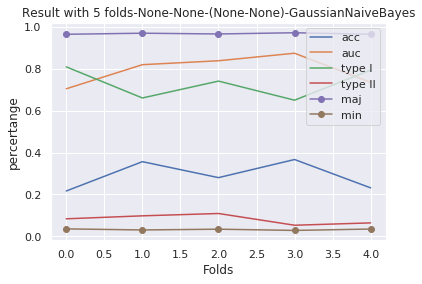

Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\calibration.py:455: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed 

Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warnin

Mean Accuracy: 0.9702305161763661
Mean Accuracy[0.9765395894428153, 0.9640762463343109, 0.9655425219941349, 0.9728739002932552, 0.9721203228173148]
Mean Auc: 0.8574197900624225
Mean Auc[0.8373686186186187, 0.9024110309017224, 0.8412667546357385, 0.8510933195592285, 0.8549592265968046]
Mean TypeII: 0.8163627124907613
Mean TypeII[0.90625, 0.8541666666666666, 0.7454545454545455, 0.7954545454545454, 0.7804878048780488]
Mean TypeI: 0.00379373213555124
Mean TypeI[0.0022522522522522522, 0.0060790273556231, 0.004583651642475172, 0.0015151515151515152, 0.0045385779122541605]


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

Mean Accuracy: 0.9567374452163697
Mean Accuracy[0.9633431085043989, 0.9501466275659824, 0.9626099706744868, 0.9582111436950147, 0.9493763756419662]
Mean Auc: 0.6655103909367168
Mean Auc[0.6548421738288471, 0.6383744557329464, 0.7105505354752343, 0.6321996437289701, 0.6915851459175866]
Mean TypeII: 0.6457917742295902
Mean TypeII[0.6744186046511628, 0.6923076923076923, 0.5555555555555556, 0.717391304347826, 0.5892857142857143]
Mean TypeI: 0.023187443896976044
Mean TypeI[0.015897047691143074, 0.030943396226415093, 0.023343373493975902, 0.018209408194233688, 0.02754399387911247]
Mean Accuracy: 0.9667117773240415
Mean Accuracy[0.9633431085043989, 0.967741935483871, 0.9611436950146628, 0.967008797653959, 0.9743213499633162]

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin


Mean Auc: 0.7043904221406505
Mean Auc[0.6170776255707763, 0.8505466860183841, 0.580558651997609, 0.833080040526849, 0.6406891065896341]
Mean TypeII: 0.9287521367521366
Mean TypeII[0.96, 0.7948717948717948, 1.0, 0.9166666666666666, 0.9722222222222222]
Mean TypeI: 0.003329815569085403
Mean TypeI[0.0015220700152207, 0.009811320754716982, 0.004555808656036446, 0.0007598784194528875, 0.0]
Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packa

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

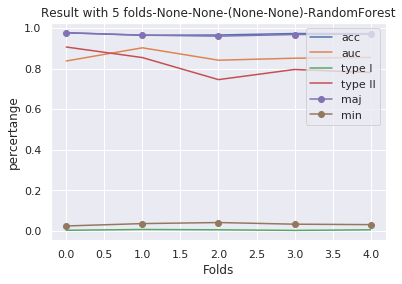

Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packa

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

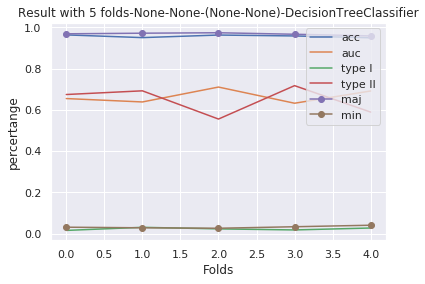

Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packa

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\An

Mean Accuracy: 0.967004602147669

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

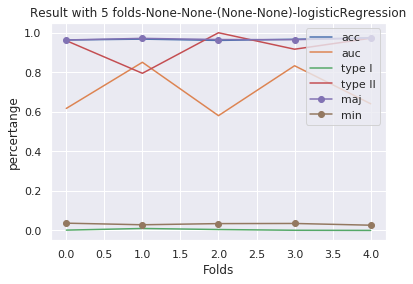


Mean Accuracy[0.9721407624633431, 0.9589442815249267, 0.967008797653959, 0.9655425219941349, 0.971386647101981]
Mean Auc: 0.6531436499801393
Mean Auc[0.6294455028975152, 0.6494756580318078, 0.6829913537230611, 0.6553821548005623, 0.6484235804477496]
Mean TypeII: 0.9875990675990677
Mean TypeII[1.0, 0.9636363636363636, 1.0, 1.0, 0.9743589743589743]
Mean TypeI: 0.001214108885032239
Mean TypeI[0.0, 0.002291825821237586, 0.0030234315948601664, 0.0, 0.0007552870090634441]
Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to De

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

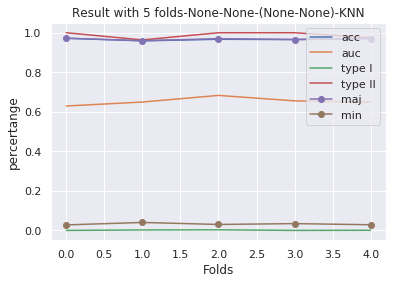

Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Mean Accuracy: 0.8656716144953667
Mean Accuracy[0.8687683284457478, 0.8533724340175953, 0.8658357771260997, 0.8599706744868035, 0.880410858400587]
Mean Auc: 0.9139184797005884
Mean Auc[0.9389721074380166, 0.9043836899358835, 0.885375772406387, 0.9160017730496454, 0.9248590556730091]
Mean TypeII: 0.17836630423839725
Mean TypeII[0.13636363636363635, 0.21428571428571427, 0.23255813953488372, 0.14583333333333334, 0.16279069767441862]
Mean TypeI: 0.13289990196920498
Mean TypeI[0.13106060606060607, 0.14447806354009077, 0.13096139288417866, 0.1398176291793313, 0.11818181818181818]


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font fa

Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packa

Mean Accuracy: 0.9677366642067373
Mean Accuracy[0.9714076246334311, 0.967008797653959, 0.9699413489736071, 0.966275659824047, 0.9640498899486427]
Mean Auc: 0.5
Mean Auc[0.5, 0.5, 0.5, 0.5, 0.5]
Mean TypeII: 1.0
Mean TypeII[1.0, 1.0, 1.0, 1.0, 1.0]
Mean TypeI: 0.0
Mean TypeI[0.0, 0.0, 0.0, 0.0, 0.0]


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

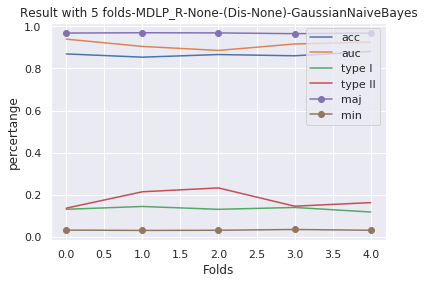

Discretization
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fon

Discretization
-------------------------------MDLP_R -----------------------------
Mean Accuracy: 0.9709644070458688
Mean Accuracy[0.968475073313783, 0.969208211143695, 0.9714076246334311, 0.968475073313783, 0.9772560528246516]
Mean Auc: 0.9422640639079131
Mean Auc[0.9396213272543059, 0.9599797365754813, 0.9395770392749244, 0.9191362715298885, 0.9530059449049653]
Mean TypeII: 0.7333333333333333
Mean TypeII[0.7291666666666666, 0.7708333333333334, 0.75, 0.75, 0.6666666666666666]
Mean TypeI: 0.005454041597818289
Mean TypeI[0.0060790273556231, 0.003799392097264438, 0.006797583081570997, 0.005319148936170213, 0.0052750565184626974]


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packa

Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

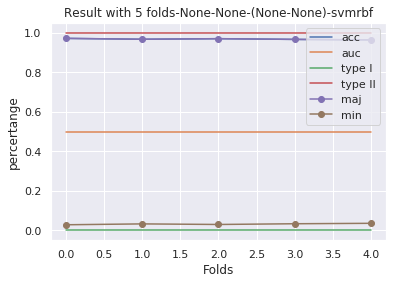

C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\calibration.py:455: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)


Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packa

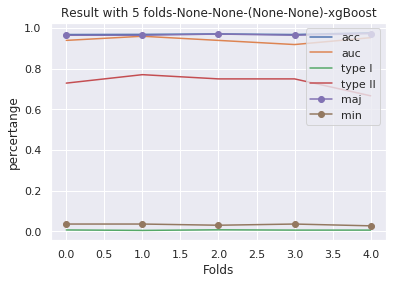

Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Discretization
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\calibration.py:455: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Lab-722\Anaconda3

Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Discretization
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Mean Accuracy: 0.9672963512004529
Mean Accuracy[0.9714076246334311, 0.9633431085043989, 0.9721407624633431, 0.968475073313783, 0.9611151870873074]
Mean Auc: 0.8284354072271164
Mean Auc[0.847489114658926, 0.8715165026898657, 0.7951297928078114, 0.8478601482316075, 0.7801814777473715]
Mean TypeII: 0.9957446808510639
Mean TypeII[1.0, 0.9787234042553191, 1.0, 1.0, 1.0]
Mean TypeI: 0.0006074411541381929
Mean TypeI[0.0, 0.0030372057706909645, 0.0, 0.0, 0.0]


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

DiscretizationDiscretization

-------------------------------MDLP_R ------------------------------------------------------------MDLP_R -----------------------------



C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

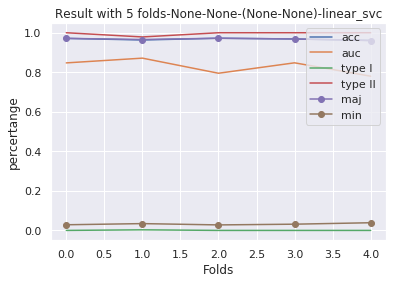

Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Discretization
DiscretizationDiscretization

-------------------------------MDLP_R ------------------------------------------------------------MDLP_R -----------------------------

-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Mean Accuracy: 0.9521927437105058
Mean Accuracy[0.9516129032258065, 0.9560117302052786, 0.9530791788856305, 0.9457478005865103, 0.954512105649303]
Mean Auc: 0.6700931381303171
Mean Auc[0.5905303030303031, 0.7106495468277945, 0.7170497185741089, 0.6083836858006042, 0.7238524364187746]
Mean TypeII: 0.6313286713286713
Mean TypeII[0.7954545454545454, 0.55, 0.5384615384615384, 0.75, 0.5227272727272727]
Mean TypeI: 0.028485052410694593
Mean TypeI[0.023484848484848483, 0.028700906344410877, 0.027439024390243903, 0.03323262839879154, 0.029567854435178165]


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

Discretization

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


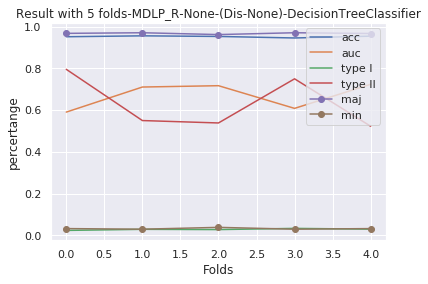


-------------------------------MDLP_R -----------------------------
Discretization
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warnin

Mean Accuracy: 0.9680297041845336
Mean Accuracy[0.967008797653959, 0.9699413489736071, 0.9640762463343109, 0.9765395894428153, 0.962582538517975]
Mean Auc: 0.9284704007909198
Mean Auc[0.9240823700754014, 0.9435241096420964, 0.9380669710806698, 0.9344793172977047, 0.9021992358587271]
Mean TypeII: 0.7444434889008262
Mean TypeII[0.7560975609756098, 0.627906976744186, 0.86, 0.7027027027027027, 0.7755102040816326]
Mean TypeI: 0.008032236907305557
Mean TypeI[0.010582010582010581, 0.010598031794095382, 0.0045662100456621, 0.00452147701582517, 0.00989345509893455]
Discretization
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarni

Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarni

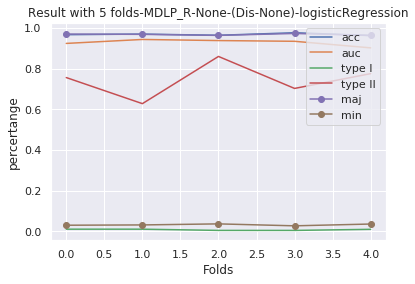

Discretization
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Mean Accuracy: 0.9696431452957617
Mean Accuracy[0.969208211143695, 0.9728739002932552, 0.9648093841642229, 0.9750733137829912, 0.9662509170946442]
Mean Auc: 0.8493422942956718
Mean Auc[0.8431669188098839, 0.8670796231771842, 0.8416362252663623, 0.868212669683258, 0.8266160345416705]
Mean TypeII: 0.832888248495804
Mean TypeII[0.9047619047619048, 0.8048780487804879, 0.82, 0.7368421052631579, 0.8979591836734694]
Mean TypeI: 0.0034846704298701625
Mean TypeI[0.0030257186081694403, 0.0030234315948601664, 0.00532724505327245, 0.004524886877828055, 0.0015220700152207]
Discretization
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


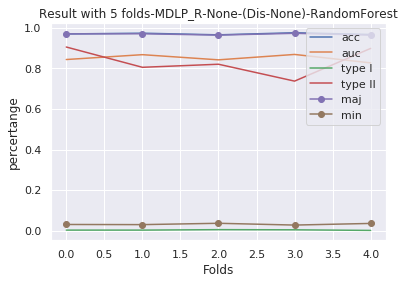

DiscretizationDiscretization

-------------------------------CAIM_R -----------------------------
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Mean Accuracy: 0.03226236759950342
Mean Accuracy[0.03225806451612903, 0.0344574780058651, 0.03372434017595308, 0.03152492668621701, 0.029347028613352897]
Mean Auc: 0.5
Mean Auc[0.5, 0.5, 0.5, 0.5, 0.5]
Mean TypeII: 0.0
Mean TypeII[0.0, 0.0, 0.0, 0.0, 0.0]
Mean TypeI: 1.0
Mean TypeI[1.0, 1.0, 1.0, 1.0, 1.0]


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

Discretization
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packa

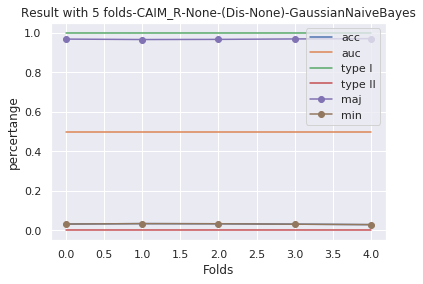

Discretization
-------------------------------ChiMerge_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Discretization
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Discretization
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Discretization
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Discretization
-------------------------------CAIM_R -----------------------------
Mean Accuracy: 0.9683241426644262
Mean Accuracy[0.9582111436950147, 0.967008797653959, 0.9728739002932552, 0.9728739002932552, 0.9706529713866471]
Mean Auc: 0.7840143764959719
Mean Auc[0.8002851560437239, 0.7800690758992502, 0.785140562248996, 0.7617388418782147, 0.7928382464096749]
Mean TypeII: 0.9062540884029529
Mean TypeII[0.9482758620689655, 0.8666666666666667, 0.8888888888888888, 0.9024390243902439, 0.925]
Mean TypeI: 0.0024225856375182193
Mean TypeI[0.0015313935681470138, 0.004548900682335102, 0.0037650602409638554, 0.0, 0.0022675736961451248]


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Mean Accuracy: 0.9689102226200184
Mean Accuracy[0.9787390029325513, 0.9706744868035191, 0.9655425219941349, 0.9618768328445748, 0.9677182685253118]
Mean Auc: 0.8033235255172965
Mean Auc[0.8272988505747126, 0.8966797633953629, 0.7646870524808357, 0.7141036600810537, 0.8138483010545178]
Mean TypeII: 0.7280855727082143
Mean TypeII[0.6, 0.660377358490566, 0.7777777777777778, 0.875, 0.7272727272727273]
Mean TypeI: 0.00757082930355131
Mean TypeI[0.008245877061469266, 0.0038138825324180014, 0.009097801364670205, 0.007598784194528876, 0.009097801364670205]
Discretization
-------------------------------ChiMerge_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Mean Accuracy: 0.9692031550207302
Mean Accuracy[0.9743401759530792, 0.9699413489736071, 0.968475073313783, 0.967741935483871, 0.9655172413793104]
Mean Auc: 0.9135267023962985
Mean Auc[0.9069117488982049, 0.9199225002105973, 0.9191195137613308, 0.9243987823439879, 0.8972809667673716]
Mean TypeII: 0.7551688572865043
Mean TypeII[0.7142857142857143, 0.7555555555555555, 0.7254901960784313, 0.76, 0.8205128205128205]
Mean TypeI: 0.006659341638545273
Mean TypeI[0.007524454477050414, 0.00530705079605762, 0.00456968773800457, 0.0045662100456621, 0.011329305135951661]


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

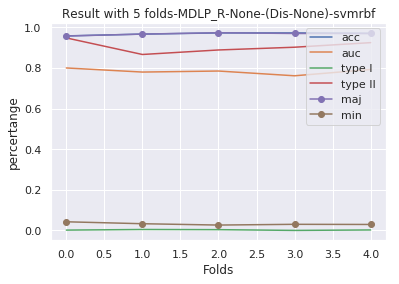

Discretization
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

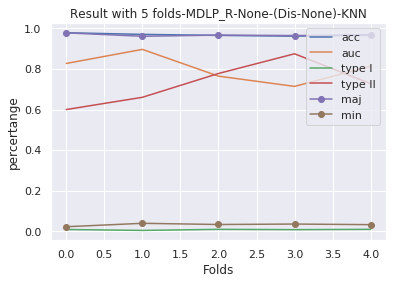

Discretization
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

Discretization
-------------------------------CAIM_R -----------------------------
Discretization
Discretization
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  

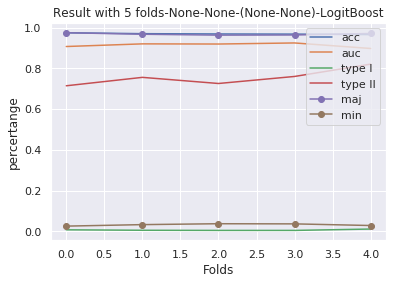

Mean Accuracy: 0.9694970556152012Discretization

Mean Accuracy[0.969208211143695, 0.9780058651026393, 0.967741935483871, 0.9626099706744868, 0.9699192956713133]
Mean Auc: 0.9406711777256076
Mean Auc[0.9427950647939785, 0.9537985234579661, 0.9545053272450532, 0.9089199709705087, 0.9433370021605315]
Mean TypeII: 0.723597834606661
-------------------------------MDLP_R -----------------------------
Mean TypeII[0.6530612244897959, 0.631578947368421, 0.68, 0.8695652173913043, 0.7837837837837838]
Mean TypeI: 0.0074271104405841375
Mean TypeI[0.0076045627376425855, 0.004524886877828055, 0.0076103500761035, 0.00834597875569044, 0.00904977375565611]


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Discretization
-------------------------------ChiMerge_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

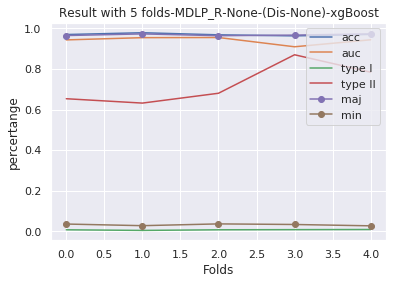

Discretization
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Discretization
-------------------------------MDLP_R -----------------------------
Discretization
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Mean Accuracy: 0.47185191799183707
Mean Accuracy[0.9699413489736071, 0.33944281524926684, 0.04618768328445748, 0.9736070381231672, 0.03008070432868672]
Mean Auc: 0.4429151530163124
Mean Auc[0.49962235649546827, 0.22224987555998013, 0.4927035330261137, 0.5, 0.5]
Mean TypeII: 0.5837136113296617
Mean TypeII[1.0, 0.9024390243902439, 0.016129032258064516, 1.0, 0.0]
Mean TypeI: 0.5304560826377135
Mean TypeI[0.0007552870090634441, 0.6530612244897959, 0.9984639016897081, 0.0, 1.0]
Discretization
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

Discretization
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

Discretization
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


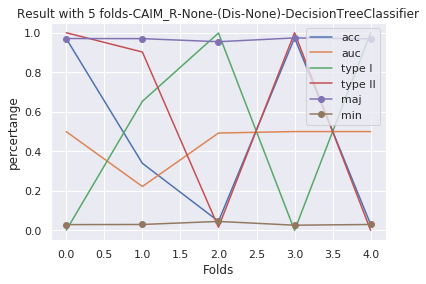

Discretization
-------------------------------ChiMerge_R -----------------------------
Discretization
-------------------------------ChiMerge_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarnin

Discretization
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Mean Accuracy: 0.9664162630733051
Mean Accuracy[0.9582111436950147, 0.967741935483871, 0.9765395894428153, 0.9706744868035191, 0.9589141599413059]
Mean Auc: 0.9302827977617467
Mean Auc[0.9118355656642236, 0.9271517349435769, 0.9496120083912096, 0.9526609510061088, 0.9101537288036144]
Mean TypeII: 0.6467758814270442
Mean TypeII[0.37777777777777777, 0.7441860465116279, 0.7027027027027027, 0.6976744186046512, 0.7115384615384616]
Mean TypeI: 0.013198857030012829
Mean TypeI[0.030326004548900682, 0.009084027252081756, 0.00452147701582517, 0.00757002271006813, 0.014492753623188406]


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

Discretization
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Discretization
Discretization
-------------------------------MDLP_R -----------------------------
-------------------------------ChiMerge_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

Discretization
-------------------------------CAIM_R -----------------------------


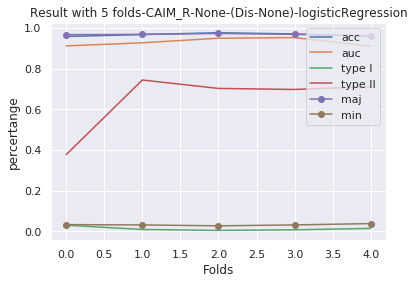

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key

Discretization
-------------------------------ChiMerge_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


DiscretizationDiscretization

-------------------------------ChiMerge_R -----------------------------
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Mean Accuracy: 0.9653926671156217
Mean Accuracy[0.9655425219941349, 0.9560117302052786, 0.9604105571847508, 0.967008797653959, 0.9779897285399853]
Mean Auc: 0.9169480263814764
Mean Auc[0.9417760770601042, 0.8866836301950806, 0.9333485540334856, 0.9270203927492446, 0.8959114778694676]
Mean TypeII: 0.6948582930756844
Mean TypeII[0.5652173913043478, 0.7407407407407407, 0.66, 0.775, 0.7333333333333333]
Mean TypeI: 0.01275153228085458
Mean TypeI[0.015933232169954476, 0.015267175572519083, 0.01598173515981735, 0.010574018126888218, 0.006001500375093774]


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\User

Discretization
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

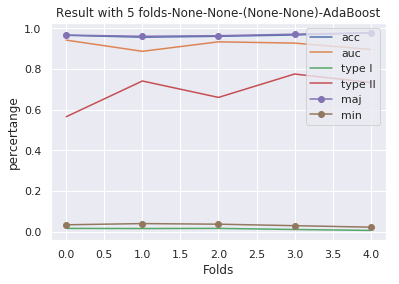

Discretization
-------------------------------MDLP_R -----------------------------
Discretization
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence 

Mean Accuracy: 0.9677367717838218
Mean Accuracy[0.967741935483871, 0.966275659824047, 0.9736070381231672, 0.966275659824047, 0.9647835656639765]
Mean Auc: 0.5846942179363099
Mean Auc[0.5212121212121211, 0.6092399551362406, 0.512769829317269, 0.7806294121528007, 0.49961977186311785]
Mean TypeII: 1.0
Mean TypeII[1.0, 1.0, 1.0, 1.0, 1.0]
Mean TypeI: 0.0
Mean TypeI[0.0, 0.0, 0.0, 0.0, 0.0]
Mean Accuracy: 0.8570156395565242
Mean Accuracy[0.8526392961876833, 0.8629032258064516, 0.8475073313782991, 0.875366568914956, 0.8466617754952311]
Mean Auc: 0.9172358107191722
Mean Auc[0.9129933816344966, 0.9234107353484851, 0.9126607230858833, 0.9305077496486691, 0.906606463878327]
Mean TypeII: 0.1611202202669788
Mean TypeII[0.17073170731707318, 0.16279069767441862, 0.17647058823529413, 0.10810810810810811, 0.1875]
Mean TypeI: 0.14232872065995544
Mean TypeI[0.14663643235071808, 0.13626040878122633, 0.15156130997715156, 0.12509419743782968, 0.1520912547528517]


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

Discretization
-------------------------------ChiMerge_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packa

Discretization
-------------------------------ChiMerge_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

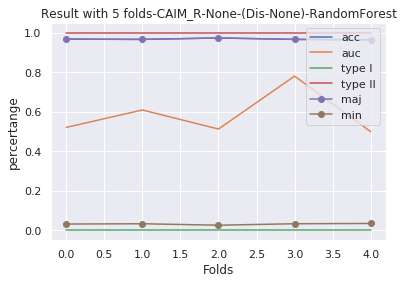

Discretization
-------------------------------ChiMerge_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packa

Discretization
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

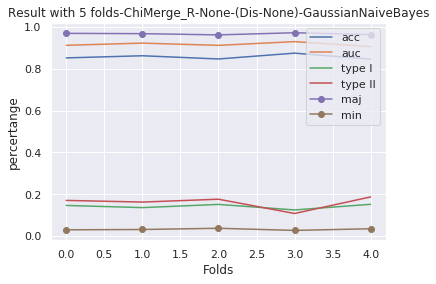

Discretization
-------------------------------CACC_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Discretization
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Discretization
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

Mean Accuracy: 0.9686178281047285
Mean Accuracy[0.9633431085043989, 0.966275659824047, 0.9765395894428153, 0.9633431085043989, 0.9735876742479824]
Mean Auc: 0.9225495795094588
Mean Auc[0.920949957591179, 0.9299684875798813, 0.8790020085666578, 0.9383409436834095, 0.944486500126167]
Mean TypeII: 0.8564147227283012
Mean TypeII[0.8888888888888888, 0.8372093023255814, 0.8064516129032258, 0.94, 0.8095238095238095]
Mean TypeI: 0.003629032532074353
Mean TypeI[0.0015267175572519084, 0.00757002271006813, 0.005251312828207052, 0.00228310502283105, 0.001514004542013626]


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

Discretization
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

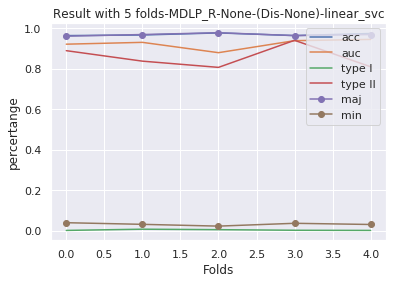

Discretization
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Discretization
-------------------------------ChiMerge_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Discretization
-------------------------------ChiMerge_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Discretization
-------------------------------CACC_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Discretization
Discretization
-------------------------------ChiMerge_R -----------------------------
-------------------------------CAIM_R -----------------------------


In [ ]:
%%time

# Classifcation Method
linear_svc = CalibratedClassifierCV(LinearSVC(max_iter=7000))
svmlinear = SVC(kernel='linear', probability=True)
svmrbf = SVC(kernel='rbf', probability=True)
DecisionTreeClassifier = tree.DecisionTreeClassifier()
RandomForest = RandomForestClassifier()
logisticRegression = LogisticRegression()
mlp = MLPClassifier()
xgBoost = xgb.XGBClassifier()
GaussianNaiveBayes = GaussianNB()
MultinomialNaiveBayes = MultinomialNB()
ComplementNaiveBayes = ComplementNB()
lboost = LogitBoost()
ada = AdaBoostClassifier()
knn = KNeighborsClassifier()

##########################################
#svmpoly = SVC(kernel='poly', probability=True)
#neigh = KNeighborsRegressor(n_neighbors=5)
#linearRegression= LinearRegression()

def run10times(classifier_list,classifier_name_list):

    classifier_list = [classifier_list]
    classifier_name_list = [classifier_name_list]
    classifier_result_list = []
    
    for idx,classifi in enumerate(classifier_list):
        result_list = []
        rounds = 2
        clf_name = classifier_name_list[idx]
        for i in range(1,rounds):

            result_list.clear()
            result_10times_baseline = []
            result_10times_MDLP = []
            result_10times_CAIM = []
            result_10times_ChiMerge_SC = []
            result_10times_ChiMerge_RG = []
            result_10times_CACC = []
            result_10times_Chi2 = []
            runnung_time_list = []

            clf = classifi
            fold = 5

            start_time = time.time()
            result_eachtimes_baseline = KFoldFuntion(clf, clf_name, 'None','None','None-None', data_list, target_list, fold, discretize_coloumn).Classify()
            result_10times_baseline.append(result_eachtimes_baseline)
            runnung_time_list.append(time.time() - start_time)

            start_time = time.time()
            result_eachtimes_MDLP = KFoldFuntion(clf, clf_name, 'MDLP_R','None','Dis-None', data_list, target_list, fold, discretize_coloumn).Classify()
            result_10times_MDLP.append(result_eachtimes_MDLP)
            runnung_time_list.append(time.time() - start_time)

            start_time = time.time()
            result_eachtimes_CAIM = KFoldFuntion(clf, clf_name, 'CAIM_R','None','Dis-None', data_list, target_list, fold, discretize_coloumn).Classify()
            result_10times_CAIM.append(result_eachtimes_CAIM)
            runnung_time_list.append(time.time() - start_time)

            start_time = time.time()
            result_eachtimes_ChiMerge_SC = KFoldFuntion(clf, clf_name, 'ChiMerge_R','None','Dis-None', data_list, target_list, fold, discretize_coloumn).Classify()
            result_10times_ChiMerge_SC.append(result_eachtimes_ChiMerge_SC)
            runnung_time_list.append(time.time() - start_time)
            
            start_time = time.time()
            result_eachtimes_CACC = KFoldFuntion(clf, clf_name, 'CACC_R','None','Dis-None', data_list, target_list, fold, discretize_coloumn).Classify()
            result_10times_CACC.append(result_eachtimes_CACC)
            runnung_time_list.append(time.time() - start_time)
            
            start_time = time.time()
            result_eachtimes_Chi2 = KFoldFuntion(clf, clf_name, 'Chi2_R','None','Dis-None', data_list, target_list, fold, discretize_coloumn).Classify()
            result_10times_Chi2.append(result_eachtimes_Chi2)
            runnung_time_list.append(time.time() - start_time)
    
        
        # Thread Lock
        lock.acquire()
        
        
        # Compare Chart (Same Classifier)
        CompareMethodMeanResult(data_name, clf_name, rounds,result_10times_baseline,result_10times_MDLP,result_10times_CAIM,result_10times_ChiMerge_SC,result_10times_CACC,result_10times_Chi2)


        # Compare Chart (Same Classifier)
        ResultEachMethodLineChart(result_10times_baseline,"Baseline",data_name,clf_name)
        ResultEachMethodLineChart(result_10times_MDLP,"MDLP_R",data_name,clf_name)
        ResultEachMethodLineChart(result_10times_CAIM,"CAIM_R",data_name,clf_name)
        ResultEachMethodLineChart(result_10times_ChiMerge_SC,"ChiMerge_R",data_name,clf_name)
        ResultEachMethodLineChart(result_10times_CACC,"CACC_R",data_name,clf_name)
        ResultEachMethodLineChart(result_10times_Chi2,"Chi2_R",data_name,clf_name)

        result_list.append(np.mean(result_10times_baseline, axis=0))
        result_list.append(np.mean(result_10times_MDLP, axis=0))
        result_list.append(np.mean(result_10times_CAIM, axis=0))
        result_list.append(np.mean(result_10times_ChiMerge_SC, axis=0))
        result_list.append(np.mean(result_10times_CACC, axis=0))
        result_list.append(np.mean(result_10times_Chi2, axis=0))

        # Single Classify Method 
        result_with_method = pd.DataFrame(result_list, index=['Baseline','MDLP_R','CAIM_R','ChiMerge_R','CACC_R','Chi2_R'], columns=['Accuracy','AUC','TypeI','TypeII'])
        result_with_method['Time(Second)'] = runnung_time_list
        print(result_with_method)

        file_time = time.strftime("%Y-%m-%d-%H%M%S", time.localtime()) 
        file_name = "Classifier_result_list_{fold}Fold_{data_name}_{clf_name}_{file_timeA}.xlsx".format(fold = fold, file_timeA = file_time,data_name=data_name,clf_name=clf_name)
        pd.DataFrame(result_with_method).to_excel("resultsexcel/"+file_name)
        
        
        # Thread Unlock
        lock.release()
    

# ---------------MultiThread: First Version---------------
# thread_start_time = time.time()

# t0 = Thread(target=run10times,args=(svmlinear,"svmlinear"))
# t1 = Thread(target=run10times,args=(linear_svc,"linear_svc"))
# t2 = Thread(target=run10times,args=(svmrbf,"svmrbf"))
# t3 = Thread(target=run10times,args=(DecisionTreeClassifier,"DecisionTreeClassifier"))
# t4 = Thread(target=run10times,args=(RandomForest,"RandomForest"))
# t5 = Thread(target=run10times,args=(logisticRegression,"logisticRegression"))
# t6 = Thread(target=run10times,args=(mlp,"mlp"))
# t7 = Thread(target=run10times,args=(xgBoost,"xgBoost"))
# t8 = Thread(target=run10times,args=(GaussianNaiveBayes,"GaussianNaiveBayes"))
# t9 = Thread(target=run10times,args=(lboost,"LogitBoost"))
# t10 = Thread(target=run10times,args=(ada,"AdaBoost"))
# t11 = Thread(target=run10times,args=(knn,"KNN"))

# #thread_list = [t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t0]
# #thread_list = [t8]
# thread_list = [t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11]
# #thread_list = [t11,t10,t9,t7,t8]

# #程式開始
# for item in thread_list:
#     item.start()
# print("\n程式開始")


# #程式結束
# for item in thread_list:
#     item.join()
# print("\n程式結束")

# thread_end_time = time.time()  
# print("First Version time :", thread_end_time - thread_start_time)  


# ---------------MultiThread: Second Version---------------

t0=[svmlinear,"svmlinear"]
t1=[linear_svc,"linear_svc"]
t2=[svmrbf,"svmrbf"]
t3=[DecisionTreeClassifier,"DecisionTreeClassifier"]
t4=[RandomForest,"RandomForest"]
t5=[logisticRegression,"logisticRegression"]
t6=[mlp,"mlp"]
t7=[xgBoost,"xgBoost"]
t8=[GaussianNaiveBayes,"GaussianNaiveBayes"]
t9=[lboost,"LogitBoost"]
t10=[ada,"AdaBoost"]
t11=[knn,"KNN"]

from multiprocessing.dummy import Pool
if __name__ == '__main__':
    thread_start_time = time.time()
    pool = Pool()
    ##### Parameter: [1,2,3,4,5];  [(knn,"KNN"),(3,4)]
    #pool.starmap(run10times, [(knn,"KNN"),(lboost,"LogitBoost")])  # work in one thread
    pool.starmap_async(run10times, [t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11]).get()
    #task = [(knn,"KNN"),(lboost,"LogitBoost"),(ada,"AdaBoost")]
#     with pool as p:
#         pool.starmap_async(run10times, (knn,"KNN")).get()
    pool.close()  
    #pool.join()    
    thread_end_time = time.time()  
    print("Second Version time :", thread_end_time - thread_start_time)  

#############################################################################YEE

## Record Result

## Compare result

print("Mean : {0}".format(np.mean(result_10times_baseline, axis=0))) 

print("Mean : {0}".format(np.mean(result_10times_MDLP, axis=0))) 

print("Mean : {0}".format(np.mean(result_10times_CAIM, axis=0)))

print("Mean : {0}".format(np.mean(result_10times_ChiMerge_SC, axis=0)))